**DS105M 2022 Week08**

**Topic:** (Re-)shaping data, data normalisation & databases

**Author:** [@jonjoncardoso](github.com/jonjoncardoso)

**Date:** 15 November 2022

---

# Setup

You might need to open the **terminal** to install packages if an `import` does not work.

**Install Plotnine:**

In [ ]:
!pip install plotnine

**💡 Tip:** Enable"Toogle Auto-Numbering" on the left-side corner of Jupyter Lab user interface.

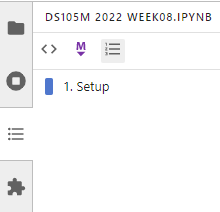


# Import packages

In [1]:
import numpy as np
import pandas as pd

# import the required libraries
import requests
from bs4 import BeautifulSoup

# Importing plotnine like this will make your life easier
from plotnine import *

# Data Collection

**Web Scraping:** [Frequent 'python' Questions](https://stackoverflow.com/questions/tagged/python)


In [2]:
# sending a request to the site
response_html = requests.get("https://stackoverflow.com/questions/tagged/python")

How many lines does this page has?

In [3]:
len(response_html.text)

321142

## What will we extract?

Let's extract the questions and related statistics

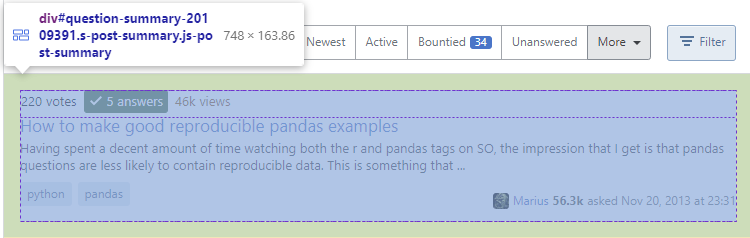

Let's explore how you would do that:

## Parse content using `BeautifulSoup`

In [4]:
# parsing page"s content
soup = BeautifulSoup(response_html.text)

# Step-by-Step is the way to go

💡Here's the key takeaway of this session: don't write code to collect all the questions. Write code to collect **ONLY ONE** question first.


## Extracting the right `div`s

After exploring the HTML, I found out I want all the `<div class="s-post-summary">` inside the main `<div id="questions">`:

In [5]:
all_posts = soup.find("div", id="questions").find_all("div", class_="s-post-summary")

print(f"We found {len(all_posts)} posts")

We found 50 posts


💡 Reinforcing the point above: even though we have 50 posts, let's collect **ONLY ONE** first.


## What is inside each `div`?

In [6]:
current_post = all_posts[0] # Select just the first one
current_post

<div class="s-post-summary js-post-summary" data-post-id="74448799" data-post-type-id="1" id="question-summary-74448799">
<div class="s-post-summary--stats js-post-summary-stats">
<div class="s-post-summary--stats-item s-post-summary--stats-item__emphasized" title="Score of 0">
<span class="s-post-summary--stats-item-number">0</span>
<span class="s-post-summary--stats-item-unit">votes</span>
</div>
<div class="s-post-summary--stats-item" title="0 answers">
<span class="s-post-summary--stats-item-number">0</span>
<span class="s-post-summary--stats-item-unit">answers</span>
</div>
<div class="s-post-summary--stats-item" title="2 views">
<span class="s-post-summary--stats-item-number">2</span>
<span class="s-post-summary--stats-item-unit">views</span>
</div>
</div>
<div class="s-post-summary--content">
<h3 class="s-post-summary--content-title">
<a class="s-link" href="/questions/74448799/python-openpyxl-copy-data-from-rows-based-on-cell-value-paste-in-specific-rows">Python Openpyxl Copy D

💡 **Here's a trick, you can use IPython.display to visualise the HTML snippet:**

In [8]:
from IPython.display import display, HTML
# HTML(str(current_post))

Another way to explore this data more visually is to save it and open it on a code editor such as [VScode](https://code.visualstudio.com/download) (We used it in the [💻 Week 07 - Lab Roadmap](https://lse-dsi.github.io/lse-ds105-course-notes/weeks/week07/lab.html))

## Let's break it all down to get the summary statistics


In [13]:
current_post.find_all("div", class_="s-post-summary--stats-item")[0]

<div class="s-post-summary--stats-item s-post-summary--stats-item__emphasized" title="Score of 0">
<span class="s-post-summary--stats-item-number">0</span>
<span class="s-post-summary--stats-item-unit">votes</span>
</div>

There are two ways to get the info I want: 

- I could extract the element `title` inside of the `<div>`
- I could extract the text inside the `<span>` elements.

**⁉️ Still puzzled about what some HTML element tags represent? The book *Duckett, Jon. HTML and CSS: Design and Build Websites. New York: Wiley, 2011.* is a great resource.**

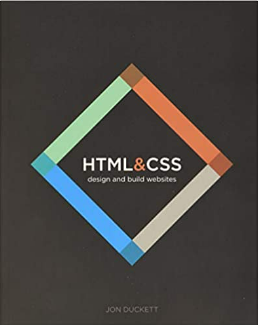

Let's do it the hard way, extract from `<span>`. I will show how to approach this with a `for` loop first, since this is probably how you learned how to do things with programming.

If I just want to print stuff, I could just navigate the tree:

In [14]:
current_div_summary = current_post.find_all("div", class_="s-post-summary--stats-item")[0]
current_div_summary

<div class="s-post-summary--stats-item s-post-summary--stats-item__emphasized" title="Score of 0">
<span class="s-post-summary--stats-item-number">0</span>
<span class="s-post-summary--stats-item-unit">votes</span>
</div>

Let's get the info we want:

In [15]:
current_div_summary.find("span",class_="s-post-summary--stats-item-unit").get_text()

'votes'

In [16]:
current_div_summary.find("span", class_="s-post-summary--stats-item-number").get_text()

'0'

This would be better if we saved it in a **pandas Series**:

In [17]:
one_summary_dict = {"unit": current_div_summary.find("span",class_="s-post-summary--stats-item-unit").get_text(),
                    "number": current_div_summary.find("span", class_="s-post-summary--stats-item-number").get_text()}
one_summary_dict

{'unit': 'votes', 'number': '0'}

In [18]:
pd.Series(one_summary_dict)

unit      votes
number        0
dtype: object

Or a **pandas DataFrame**

In [23]:
pd.DataFrame(one_summary_dict, index=[0]) # do you know why we need the `index=[0]` bit here?

,unit,number
0,votes,0


## Putting the pieces of the puzzle together: gathering summary statistics for a single post

However, the part people struggle the most is figuring out how to **pre-process and store the data** correctly. 

If you follow the strategy above, it will be much easier to think about that. Let's explore together how we would gather **all statistics** from a `current_div_summary`:


In [24]:
all_stats = [] # an empty list that will be filled with multiple dictionaries (do you see why? ask your lecturer if not)

for current_div_summary  in current_post.find_all("div", class_="s-post-summary--stats-item"):
    one_summary_dict = {"unit": current_div_summary.find("span",class_="s-post-summary--stats-item-unit").get_text(),
                        "number": current_div_summary.find("span", class_="s-post-summary--stats-item-number").get_text()}
    all_stats.append(one_summary_dict)

# What is in `all_stats` now?
all_stats

[{'unit': 'votes', 'number': '0'},
 {'unit': 'answers', 'number': '0'},
 {'unit': 'views', 'number': '2'}]

What happens if we try to convert it to a Series?

In [25]:
pd.Series(all_stats)

0      {'unit': 'votes', 'number': '0'}
1    {'unit': 'answers', 'number': '0'}
2      {'unit': 'views', 'number': '2'}
dtype: object

What happens if we try to convert it to a DataFrame?

In [26]:
pd.DataFrame(all_stats)

,unit,number
0,votes,0
1,answers,0
2,views,2


**🎯 ACTION POINT**: Would you organise this dataframe differently?

## Going one step up: gathering summary statistics for ALL posts

How would we gather the summary for **ALL posts**?

In [27]:
all_stats = []
for current_post in all_posts:
    for current_div_summary  in current_post.find_all("div", class_="s-post-summary--stats-item"):
        one_summary_dict = {"unit": current_div_summary.find("span",class_="s-post-summary--stats-item-unit").get_text(),
                            "number": current_div_summary.find("span", class_="s-post-summary--stats-item-number").get_text()}
        all_stats.append(one_summary_dict)

# What is in `all_stats` now?
all_stats

[{'unit': 'votes', 'number': '0'},
 {'unit': 'answers', 'number': '0'},
 {'unit': 'views', 'number': '2'},
 {'unit': 'votes', 'number': '0'},
 {'unit': 'answers', 'number': '0'},
 {'unit': 'views', 'number': '2'},
 {'unit': 'votes', 'number': '0'},
 {'unit': 'answers', 'number': '0'},
 {'unit': 'views', 'number': '6'},
 {'unit': 'votes', 'number': '0'},
 {'unit': 'answers', 'number': '0'},
 {'unit': 'views', 'number': '2'},
 {'unit': 'votes', 'number': '0'},
 {'unit': 'answers', 'number': '0'},
 {'unit': 'views', 'number': '3'},
 {'unit': 'votes', 'number': '0'},
 {'unit': 'answers', 'number': '0'},
 {'unit': 'views', 'number': '2'},
 {'unit': 'votes', 'number': '0'},
 {'unit': 'answers', 'number': '0'},
 {'unit': 'views', 'number': '5'},
 {'unit': 'votes', 'number': '0'},
 {'unit': 'answers', 'number': '0'},
 {'unit': 'views', 'number': '3'},
 {'unit': 'votes', 'number': '0'},
 {'unit': 'answers', 'number': '0'},
 {'unit': 'views', 'number': '7'},
 {'unit': 'votes', 'number': '0'},
 {

**🤔 Q: What is the problem with the dictionary above?**

In [28]:
pd.DataFrame(all_stats)

,unit,number
0,votes,0
1,answers,0
2,views,2
3,votes,0
4,answers,0
...,...,...
145,answer,1
146,views,19
147,votes,0
148,answer,1


A: Well, I have the statistics about all the 50 posts but I don't know which one is which!

Let's fix that:

In [29]:
# h3 class="s-post-summary--content-title"

all_stats = []
for current_post in all_posts:
    post_title = current_post.find("h3", class_="s-post-summary--content-title").get_text().strip()
    post_time  = current_post.find("time").span["title"]
    
    for current_div_summary  in current_post.find_all("div", class_="s-post-summary--stats-item"):
        one_summary_dict = {"post_title" : post_title,
                            "post_time"  : post_time, 
                            "unit"       : current_div_summary.find("span",class_="s-post-summary--stats-item-unit").get_text(),
                            "number"     : current_div_summary.find("span", class_="s-post-summary--stats-item-number").get_text()}
        all_stats.append(one_summary_dict)

# What is in `all_stats` now?
all_stats

[{'post_title': 'Python Openpyxl Copy Data From Rows Based on Cell Value& Paste In Specific Rows of ExcelSheet',
  'post_time': '2022-11-15 16:11:01Z',
  'unit': 'votes',
  'number': '0'},
 {'post_title': 'Python Openpyxl Copy Data From Rows Based on Cell Value& Paste In Specific Rows of ExcelSheet',
  'post_time': '2022-11-15 16:11:01Z',
  'unit': 'answers',
  'number': '0'},
 {'post_title': 'Python Openpyxl Copy Data From Rows Based on Cell Value& Paste In Specific Rows of ExcelSheet',
  'post_time': '2022-11-15 16:11:01Z',
  'unit': 'views',
  'number': '2'},
 {'post_title': 'CMOS XOR propagation delay in Python',
  'post_time': '2022-11-15 16:10:52Z',
  'unit': 'votes',
  'number': '0'},
 {'post_title': 'CMOS XOR propagation delay in Python',
  'post_time': '2022-11-15 16:10:52Z',
  'unit': 'answers',
  'number': '0'},
 {'post_title': 'CMOS XOR propagation delay in Python',
  'post_time': '2022-11-15 16:10:52Z',
  'unit': 'views',
  'number': '2'},
 {'post_title': 'Why is my return

In [30]:
pd.DataFrame(all_stats)

,post_title,post_time,unit,number
0,Python Openpyxl Copy Data From Rows Based on C...,2022-11-15 16:11:01Z,votes,0
1,Python Openpyxl Copy Data From Rows Based on C...,2022-11-15 16:11:01Z,answers,0
2,Python Openpyxl Copy Data From Rows Based on C...,2022-11-15 16:11:01Z,views,2
3,CMOS XOR propagation delay in Python,2022-11-15 16:10:52Z,votes,0
4,CMOS XOR propagation delay in Python,2022-11-15 16:10:52Z,answers,0
...,...,...,...,...
145,Merge List in Python next to the same index,2022-11-15 15:29:57Z,answer,1
146,Merge List in Python next to the same index,2022-11-15 15:29:57Z,views,19
147,Python web scrape br and i tag,2022-11-15 15:27:19Z,votes,0
148,Python web scrape br and i tag,2022-11-15 15:27:19Z,answer,1


['votes', 'answers', 'views', 'votes', 'answers', ..., 'answer', 'views', 'votes', 'answer', 'views']
Length: 150
Categories (5, object): ['views' < 'vote' < 'votes' < 'answer' < 'answers']

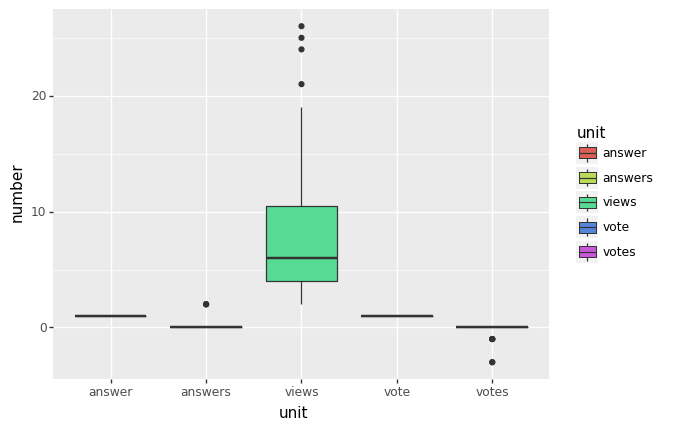

<ggplot: (160415314224)>

In [54]:
plot_df = pd.DataFrame(all_stats)
plot_df["number"] = plot_df["number"].astype(int)
# plot_df["unit"] = pd.Categorical(plot_df["unit"], categories=["views", "vote", "votes", "answer", "answers"], ordered=True)

g = (
 ggplot(plot_df, aes(x="unit", y="number", group="unit", fill="unit"))
   + geom_boxplot()
)

g

# Functions

Don't underestimate the power of functions!

In fact, you might find it easier to work with them than with `for` loops

## A function just to parse the `current_div_summary`

Check [numpy docstring convention](https://numpydoc.readthedocs.io/en/latest/format.html) for documenting functions

In [55]:
def parse_div_summary(current_div_summary):
    """
    # Let's write documentation together
    """
    
    one_summary_dict = pd.DataFrame({"unit"   : current_div_summary.find("span",class_="s-post-summary--stats-item-unit").get_text(),
                                     "number" : current_div_summary.find("span", class_="s-post-summary--stats-item-number").get_text()}, index=[0])
    return one_summary_dict

In [59]:
parse_div_summary(current_div_summary)

,unit,number
0,views,12


## A function to parse all summaries from a `current_post`

Time to learn about `pd.concat()`

list comprehension

In [60]:
all_numbers = []
for i in range(10):
    all_numbers.append(i)
all_numbers

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [61]:
[i for i in range(10)]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [70]:
def parse_all_summaries(current_post):
    all_summaries = pd.concat([parse_div_summary(div_summary) 
                               for div_summary in current_post.find_all("div", class_="s-post-summary--stats-item")])
    return all_summaries


In [71]:
parse_all_summaries(current_post)

,unit,number
0,votes,0
0,answer,1
0,views,12


## A function to parse other info about a `current_post`

Time to learn how to expand a dataframe

In [72]:
def parse_post_div(current_post):
    post_title = current_post.find("h3", class_="s-post-summary--content-title").get_text().strip()
    post_time  = current_post.find("time").span["title"]
    
    df_summary = parse_all_summaries(current_post)
    # We can reuse the dataframe that returned from `parse_all_summaries`
    df_summary["post_title"] = post_title
    df_summary["post_time"]  = post_time
    return df_summary

In [73]:
parse_post_div(current_post)

,unit,number,post_title,post_time
0,votes,0,Python web scrape br and i tag,2022-11-15 15:27:19Z
0,answer,1,Python web scrape br and i tag,2022-11-15 15:27:19Z
0,views,12,Python web scrape br and i tag,2022-11-15 15:27:19Z


## A function to parse ALL posts

Instead of growing a list using `for` loops, let's use list comprehension and use `pd.concat()`

Time to learn about `reset_index()` and `inplace=True`

In [74]:
def parse_all_posts(soup):
    all_posts = soup.find("div", id="questions").find_all("div", class_="s-post-summary")
    df_results = pd.concat([parse_post_div(current_post) for current_post in all_posts])
    
    # Optional: If you are also annoyed at the zero indices
    # df_results.reset_index(drop=True, inplace=True)
    return df_results

In [75]:
parse_all_posts(soup)

,unit,number,post_title,post_time
0,votes,0,Python Openpyxl Copy Data From Rows Based on C...,2022-11-15 16:11:01Z
0,answers,0,Python Openpyxl Copy Data From Rows Based on C...,2022-11-15 16:11:01Z
0,views,2,Python Openpyxl Copy Data From Rows Based on C...,2022-11-15 16:11:01Z
0,votes,0,CMOS XOR propagation delay in Python,2022-11-15 16:10:52Z
0,answers,0,CMOS XOR propagation delay in Python,2022-11-15 16:10:52Z
...,...,...,...,...
0,answer,1,Merge List in Python next to the same index,2022-11-15 15:29:57Z
0,views,19,Merge List in Python next to the same index,2022-11-15 15:29:57Z
0,votes,0,Python web scrape br and i tag,2022-11-15 15:27:19Z
0,answer,1,Python web scrape br and i tag,2022-11-15 15:27:19Z


## Putting it all together

- Use Jupyter Notebook/Google Colab for prototyping, but not for reusing code
- Store your functions in a separate file

In [76]:
import pandas as pd
from bs4 import BeautifulSoup

def parse_div_summary(current_div_summary):
    """
    # Let's write documentation together
    """
    
    one_summary_dict = pd.DataFrame({"unit"   : current_div_summary.find("span",class_="s-post-summary--stats-item-unit").get_text(),
                                     "number" : current_div_summary.find("span", class_="s-post-summary--stats-item-number").get_text()}, index=[0])
    return one_summary_dict

def parse_all_summaries(current_post):
    all_summaries = pd.concat([parse_div_summary(div_summary) for div_summary in current_post.find_all("div", class_="s-post-summary--stats-item")])
    return all_summaries

def parse_post_div(current_post):
    post_title = current_post.find("h3", class_="s-post-summary--content-title").get_text().strip()
    post_time  = current_post.find("time").span["title"]
    
    df_summary = parse_all_summaries(current_post)
    # We can reuse the dataframe that returned from `parse_all_summaries`
    df_summary["post_title"] = post_title
    df_summary["post_time"]  = post_time
    return df_summary

def parse_all_posts(soup):
    all_posts = soup.find("div", id="questions").find_all("div", class_="s-post-summary")
    df_results = pd.concat([parse_post_div(current_post) for current_post in all_posts])
    
    # Optional: If you are also annoyed at the zero indices
    # df_results.reset_index(drop=True, inplace=True)
    return df_results

**🎯 ACTION POINT**: 

- In the same folder as this notebook, create a new folder and call it `stackparser`
- Create an **empty file** at `stackparser/__init__.py` (it has to be named exactly like that)
- Move the code above to a `stackparser/questions.py` file

The code below should return the same `df` as we have been creating:

In [77]:
import stackparser
import stackparser.questions

# or alternatively:
# import stackparser
# from stackparser.questions import parse_all_posts

In [7]:
import requests
from bs4 import BeautifulSoup

import pandas as pd
import stackparser
import stackparser.questions

response_html = requests.get("https://stackoverflow.com/questions/tagged/python")
soup = BeautifulSoup(response_html.text)

df = stackparser.questions.parse_all_posts(soup)
df

,unit,number,post_title,post_time
0,votes,0,"How Moving , Scaling and Rotating an objects w...",2022-11-15 17:47:45Z
0,answers,0,"How Moving , Scaling and Rotating an objects w...",2022-11-15 17:47:45Z
0,views,5,"How Moving , Scaling and Rotating an objects w...",2022-11-15 17:47:45Z
0,votes,0,Running python script with tkinter gui on Ubun...,2022-11-15 17:47:42Z
0,answers,0,Running python script with tkinter gui on Ubun...,2022-11-15 17:47:42Z
...,...,...,...,...
0,answers,2,How I end a loop for not sum first and last nu...,2022-11-15 17:06:23Z
0,views,18,How I end a loop for not sum first and last nu...,2022-11-15 17:06:23Z
0,votes,0,Python - Recursive function returns Runtime Er...,2022-11-15 17:06:02Z
0,answers,0,Python - Recursive function returns Runtime Er...,2022-11-15 17:06:02Z


### Resulting DataFrame

In [6]:
df = parse_all_posts(soup)
df.shape

NameError: name 'parse_all_posts' is not defined

In [8]:
df.describe()

,unit,number,post_title,post_time
count,150,150,150,150
unique,5,28,50,50
top,views,0,"How Moving , Scaling and Rotating an objects w...",2022-11-15 17:47:45Z
freq,50,76,3,3


In [9]:
df.dtypes

unit          object
number        object
post_title    object
post_time     object
dtype: object

What does the above mean?

**🎯 ACTION POINT**: Would you organise this dataframe differently?

> text here

# Pre-processing the data

## Convert column `time` to a proper datetime type

- Using pandas [time series capabilities](https://pandas.pydata.org/docs/user_guide/timeseries.html)
- Using pandas [`assign` function](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.assign.html)
- Read more about python [lambda functions](https://www.w3schools.com/python/python_lambda.asp)

In [10]:
# Luckily the column `time` is already well formatted:
pd.to_datetime(df["post_time"])

0   2022-11-15 17:47:45+00:00
0   2022-11-15 17:47:45+00:00
0   2022-11-15 17:47:45+00:00
0   2022-11-15 17:47:42+00:00
0   2022-11-15 17:47:42+00:00
               ...           
0   2022-11-15 17:06:23+00:00
0   2022-11-15 17:06:23+00:00
0   2022-11-15 17:06:02+00:00
0   2022-11-15 17:06:02+00:00
0   2022-11-15 17:06:02+00:00
Name: post_time, Length: 150, dtype: datetime64[ns, UTC]

In [11]:
df.assign(post_time_formatted=lambda x: pd.to_datetime(x["post_time"]))

,unit,number,post_title,post_time,post_time_formatted
0,votes,0,"How Moving , Scaling and Rotating an objects w...",2022-11-15 17:47:45Z,2022-11-15 17:47:45+00:00
0,answers,0,"How Moving , Scaling and Rotating an objects w...",2022-11-15 17:47:45Z,2022-11-15 17:47:45+00:00
0,views,5,"How Moving , Scaling and Rotating an objects w...",2022-11-15 17:47:45Z,2022-11-15 17:47:45+00:00
0,votes,0,Running python script with tkinter gui on Ubun...,2022-11-15 17:47:42Z,2022-11-15 17:47:42+00:00
0,answers,0,Running python script with tkinter gui on Ubun...,2022-11-15 17:47:42Z,2022-11-15 17:47:42+00:00
...,...,...,...,...,...
0,answers,2,How I end a loop for not sum first and last nu...,2022-11-15 17:06:23Z,2022-11-15 17:06:23+00:00
0,views,18,How I end a loop for not sum first and last nu...,2022-11-15 17:06:23Z,2022-11-15 17:06:23+00:00
0,votes,0,Python - Recursive function returns Runtime Er...,2022-11-15 17:06:02Z,2022-11-15 17:06:02+00:00
0,answers,0,Python - Recursive function returns Runtime Er...,2022-11-15 17:06:02Z,2022-11-15 17:06:02+00:00


If we want to store this new column, we need to re-assign the dataframe `df`

In [12]:
df = df.assign(post_time_formatted=lambda x: pd.to_datetime(x["post_time"]))

In [ ]:
df.dtypes

## Let's create three columns: `votes`, `answers`, `views`

- That is a task for pandas [pivot_table](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html)

In [13]:
df.pivot_table(values="number", columns="unit", index=["post_title", "post_time_formatted"])

,unit,answer,answers,views,vote,votes
post_title,post_time_formatted,,,,,
Are participants who identify as female more likely to make a zero contribution than those who identify as male? [closed],2022-11-15 17:32:06+00:00,NaN,0.0,16.0,NaN,-6.0
CSV File editing in pytho,2022-11-15 17:15:31+00:00,NaN,0.0,11.0,NaN,-2.0
Can't run youtube file on terminal,2022-11-15 17:22:25+00:00,NaN,0.0,16.0,NaN,0.0
Concatenate dataframes without doubling columns number,2022-11-15 17:45:03+00:00,NaN,0.0,10.0,NaN,0.0
"Converting a list of triplets (row, column, value) to matrix as pandas df",2022-11-15 17:09:40+00:00,NaN,0.0,5.0,NaN,0.0
"Fast ways of accessing core data (via gdb, external library, etc)",2022-11-15 17:21:34+00:00,NaN,0.0,11.0,NaN,0.0
Find the range of a multivariate function with Sympy (Python),2022-11-15 17:18:00+00:00,NaN,0.0,7.0,NaN,0.0
"Flask Admin - create inline model from ""editable"" popup in list view?",2022-11-15 17:17:09+00:00,NaN,0.0,5.0,NaN,0.0
GPA Calculator troubles,2022-11-15 17:17:57+00:00,NaN,0.0,9.0,NaN,0.0


What can we improve about the DF above?

**🤝 WORKING TOGETHER**

- Modify the functions we created in the `stackparser/questions.py` file so that:
    - `answer` is renamed to `answers`
    - `vote` is renamed to `votes`
- Recreate the Dataframe (code below) and see the difference!

Sadly, Jupyter will not recognise your changes unless you restart and re-run the Python session. You can do that, or, alternatively, add a chunk of code to the top of your notebook and add the two lines below to ["reload"](https://stackoverflow.com/a/44977335/843365) functions.

```python
%load_ext autoreload
%autoreload 2
```

In [ ]:
import requests
import pandas as pd

from bs4 import BeautifulSoup

import stackparser
from stackparser.questions import parse_all_posts

response_html = requests.get("https://stackoverflow.com/questions/tagged/python")
soup = BeautifulSoup(response_html.text)

# Note that we piped the output of `parse_all_posts()` to the `assign` function. That is very common to do with Pandas
df = (
    parse_all_posts(soup)
    .assign(post_time_formatted=lambda x: pd.to_datetime(x["post_time"]))
    .pivot_table(values="number", columns="unit", index=["post_title", "post_time_formatted"])
)

df